In [4]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from   IPython.core.display import HTML
import numpy as np
from   datetime import datetime, timedelta
from   pandas.tseries.offsets import *
import seaborn as sns

## Processing and Importing Dataframes  <a class="anchor" id="processing"></a>
[ToC](#contents)

In [5]:
# Read in Dataframes
dfReuters = pd.read_csv(r'C:\Users\Arnau\Imperial College London/New Merged Sentiment Reuters.csv')
dfMW = pd.read_csv(r'C:\Users\Arnau\Imperial College London/New Merged Sentiment MW.csv')
dfTMF = pd.read_csv(r'C:\Users\Arnau\Imperial College London/New Merged Sentiment TMF.csv')

dfsentimentFrames = [dfReuters, dfMW, dfTMF]
dfsentiment = pd.concat(dfsentimentFrames)
dfsentimentStore = dfsentiment.copy()
dfsentiment = dfsentiment.groupby(['Date','Company']).mean().reset_index()

dfticker = pd.read_csv(r'C:\Users\Arnau\Imperial College London/Company Ticker.csv')
dfreturns = pd.read_csv(r'C:\Users\Arnau\Imperial College London/Returns.csv')


# Change datetime
dfsentiment['Date'] = pd.to_datetime(dfsentiment['Date'])
dfreturns['Date'] = pd.to_datetime(dfreturns['prd'].astype(str), format='%Y%m%d')
lst = pd.bdate_range(start = '2015-02-03', end = '2021-06-17').tolist()

# Drop redundant columns
dfticker = dfticker.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
dfreturns = dfreturns.drop(['Unnamed: 0', 'prd'], axis = 1)
dfreturns = dfreturns[['Date', 'int_tick', 'tret']]
dfsentiment = dfsentiment.drop(['Unnamed: 0'], axis = 1)

# Rename columns
dfticker = dfticker.rename(columns={'Company Name': 'Company'})
dfreturns = dfreturns.rename(columns={'int_tick': 'Ticker', 'tret': 'Return'})


# Map Tickers and Returns onto dfsentiment
dfsentiment = dfsentiment.merge(dfticker, how='left').merge(dfreturns, how='left')

# Calculate Average Sentiment and Rolling mean (yday + today)
dfsentiment['Average'] = dfsentiment[['LMD_Polarity']].mean(axis=1, skipna=True)
dfsentiment = dfsentiment[['Date', 'Company', 'Ticker', 'LMD_Polarity', 'Return']]

# Remove weekends and companies not in Investable Universe
# dfsentiment = dfsentiment[dfsentiment['Date'].dt.weekday < 5] # Remove weekends
no_return_list = list(dfsentiment[dfsentiment['Ticker'].isna()]['Company'].unique()) # Remove companies not in IU
dfsentiment = dfsentiment[~dfsentiment['Company'].isin(no_return_list)]
dfsentiment = dfsentiment.dropna(subset=['Return'])

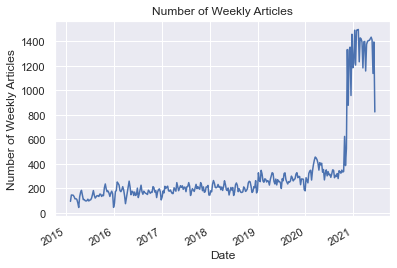

In [6]:
# dfsentimentStore['Date'] = pd.to_datetime(dfsentimentStore['Date'])

# # Drop redundant columns
# dfsentimentStore = dfsentimentStore.drop(['Unnamed: 0'], axis = 1)
sns.set()
dfsentimentStore = dfsentiment.dropna()
dfsentimentStore
dfsentimentStore['Date'].sub(pd.to_timedelta(dfsentimentStore['Date'].dt.dayofweek, unit='D')).value_counts(sort=False).iloc[:-1].plot(title='Number of Weekly Articles', ylabel='Number of Weekly Articles', xlabel='Date')
plt.savefig("Weeklyarticleevolution1.pdf", dpi=300, bbox_inches='tight') # save as pdf
#IT IS NOT REALLY THE NUMBER OF ARTICLES, BUT THE NUMBER OF SENTIMENT DATAPOINTS, 
#THIS IS BECAUSE WHEN WE HAVE 3 ARTICLES IN THE SAME DAY, THE SENTIMENT IS AVERAGED AND COUNTED AS A SINGLE SENTIMENT DATAPOINT,
#THIS IS WHY THE SUM OF ARTICLES IS LOWER THAN THE 450K WE INITIALLY HAD
#(IT IS ALSO LOWER BC WE ONLY DID 2015-2021)


## 10% Portfolio  <a class="anchor" id="10"></a>
[ToC](#contents)

In [9]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.1 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.1 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [10]:
newportfolio10 = pd.DataFrame(dict_ret).transpose()
newportfolio10 = newportfolio10.rename(columns={0: 'LMD_Polarity'})
newportfolio10.to_csv('10percentportfolio.csv')

#print(newportfolio10.head())

In [11]:
newportfolio10 = pd.read_csv('10percentportfolio.csv')
newportfolio10 = newportfolio10.rename(columns={'Unnamed: 0': 'Date'})
methodreturn = newportfolio10[['LMD_Polarity']]

mean_return = methodreturn.mean()
std_return = methodreturn.std()
businessDays = 252
annual_factor = np.sqrt(businessDays)
SR = (mean_return*annual_factor)/(std_return)
snr10=SR
print(SR)


LMD_Polarity    0.281435
dtype: float64


## 20% Porfolio  <a class="anchor" id="20"></a>
[ToC](#contents)

In [12]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.2 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.2 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [13]:
newportfolio20 = pd.DataFrame(dict_ret).transpose()
newportfolio20 = newportfolio20.rename(columns={0: 'LMD_Polarity'})
newportfolio20.to_csv('20percentportfolio.csv')

In [15]:
newportfolio20 = pd.read_csv('20percentportfolio.csv')
newportfolio20 = newportfolio20.rename(columns={'Unnamed: 0': 'Date'})
# newportfolio20 = newportfolio20[~(newportfolio20['Date'] < '2019-01-01')]
methodreturn = newportfolio20[['LMD_Polarity']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())
snr20=SR
print(SR)

LMD_Polarity    0.891924
dtype: float64


## 30% Porfolio  <a class="anchor" id="30"></a>
[ToC](#contents)

In [16]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.3 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.3 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [17]:
newportfolio30 = pd.DataFrame(dict_ret).transpose()
newportfolio30 = newportfolio30.rename(columns={0: 'LMD_Polarity'})
newportfolio30.to_csv('30percentportfolio.csv')

In [18]:
newportfolio30 = pd.read_csv('30percentportfolio.csv')
newportfolio30 = newportfolio30.rename(columns={'Unnamed: 0': 'Date'})
# newportfolio30 = newportfolio30[~(newportfolio30['Date'] < '2019-01-01')]
methodreturn = newportfolio30[['LMD_Polarity']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())
snr30=SR
print(SR)


LMD_Polarity    0.567104
dtype: float64


## 40% Porfolio  <a class="anchor" id="40"></a>
[ToC](#contents)

In [19]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.4 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.4 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [20]:
newportfolio40 = pd.DataFrame(dict_ret).transpose()
newportfolio40 = newportfolio40.rename(columns={0: 'LMD_Polarity'})
newportfolio40.to_csv('40percentportfolio.csv')

In [21]:
newportfolio40 = pd.read_csv('40percentportfolio.csv')
newportfolio40 = newportfolio40.rename(columns={'Unnamed: 0': 'Date'})
# newportfolio40 = newportfolio40[~(newportfolio30['Date'] < '2019-01-01')]
methodreturn = newportfolio40[['LMD_Polarity']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())
snr40=SR
print(SR)


LMD_Polarity    0.625273
dtype: float64


## 50% Portfolio  <a class="anchor" id="50"></a>
[ToC](#contents)

In [22]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.5 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.5 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [23]:
newportfolio50 = pd.DataFrame(dict_ret).transpose()
newportfolio50 = newportfolio50.rename(columns={0: 'LMD_Polarity'})
newportfolio50.to_csv('50percentportfolio.csv')

In [24]:
newportfolio50 = pd.read_csv('50percentportfolio.csv')
newportfolio50 = newportfolio50.rename(columns={'Unnamed: 0': 'Date'})
methodreturn = newportfolio50[['LMD_Polarity']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())
snr50=SR
print(SR)


LMD_Polarity    0.574919
dtype: float64


<Figure size 576x432 with 0 Axes>

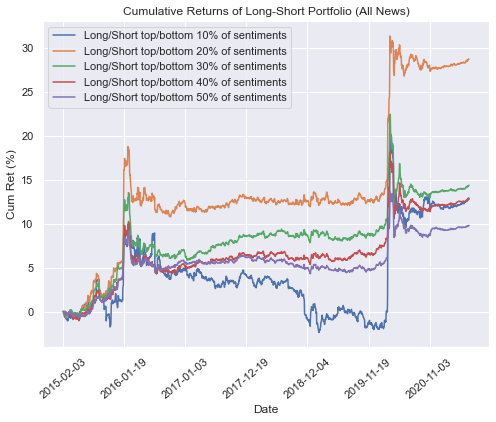

In [27]:
Total_df=newportfolio10.copy()
Total_df.rename(columns={"LMD_Polarity":"10%"}, inplace=True)
#print(Total_df.head())
Total_df['20%']=newportfolio20['LMD_Polarity']
Total_df['30%']=newportfolio30['LMD_Polarity']
Total_df['40%']=newportfolio40['LMD_Polarity']
Total_df['50%']=newportfolio50['LMD_Polarity']
#print(Total_df.head())
plt.figure()
Total_df_final = Total_df.set_index('Date')
Total_df_final.cumsum().plot()

plt.xticks(rotation=40)
plt.title('Cumulative Returns of Long-Short Portfolio (All News)')
plt.xlabel('Date')
plt.ylabel('Cum Ret (%)')
plt.grid(True)
plt.legend(['Long/Short top/bottom 10% of sentiments', 'Long/Short top/bottom 20% of sentiments', 'Long/Short top/bottom 30% of sentiments', 'Long/Short top/bottom 40% of sentiments', 'Long/Short top/bottom 50% of sentiments'])
plt.rcParams["figure.figsize"] = (8, 8)
plt.savefig("portfolio1.pdf", dpi=300, bbox_inches='tight') # save as pdf

In [28]:
print(snr10)
print(snr20)
print(snr30)
print(snr40)
print(snr50)

LMD_Polarity    0.281435
dtype: float64
LMD_Polarity    0.891924
dtype: float64
LMD_Polarity    0.567104
dtype: float64
LMD_Polarity    0.625273
dtype: float64
LMD_Polarity    0.574919
dtype: float64
